# Libraries & Tools

In [1]:
# for manupilating data
import pandas as pd
import numpy as ny

# for visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# settings
%matplotlib inline
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)
sns.set_style("darkgrid")
plt.style.use("seaborn")

# ml tools
from sklearn.model_selection import train_test_split # to split the data as obvious
from sklearn.preprocessing import StandardScaler # to scale our features

# models
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.ensemble import (AdaBoostRegressor,
                              RandomForestRegressor,
                              ExtraTreesRegressor, 
                              GradientBoostingRegressor)
from sklearn.linear_model import (LinearRegression,
                                  Ridge,
                                  Lasso,
                                  ElasticNet)

# metrics
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import cross_val_predict

# Data Cleaning

In [2]:
df = pd.read_csv("/kaggle/input/autompg-dataset/auto-mpg.csv")
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [3]:
df.shape

(398, 9)

In [4]:
df.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight            int64
acceleration    float64
model year        int64
origin            int64
car name         object
dtype: object

>Okay, I think all columns are good **except**: <br>
>- **`horsepower`** should be **`Numeric`**.<br>
>- **`origin`** should be **`Categorical`**.

In [5]:
df["horsepower"] = pd.to_numeric(df["horsepower"], errors = "coerce")
df["origin"] = df["origin"].astype("object")

# test
assert df["horsepower"].dtype == "float64"
assert df["origin"].dtype == "object"

In [6]:
df.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

In [7]:
filt = df["horsepower"].isna()
df[filt]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
32,25.0,4,98.0,NaN,2046,19.0,71,1,ford pinto
126,21.0,6,200.0,NaN,2875,17.0,74,1,ford maverick
330,40.9,4,85.0,NaN,1835,17.3,80,2,renault lecar deluxe
336,23.6,4,140.0,NaN,2905,14.3,80,1,ford mustang cobra
354,34.5,4,100.0,NaN,2320,15.8,81,2,renault 18i
374,23.0,4,151.0,NaN,3035,20.5,82,1,amc concord dl


> **Observations :** <br>
We have **`6`** null valus in **`horsepower`**. <br>
I will impute them with the **`median`**.

In [8]:
horse_pwr_median = df["horsepower"].median()
df["horsepower"].fillna(horse_pwr_median, inplace = True)

# test
assert df["horsepower"].isna().sum() == 0

In [9]:
# I will see how many duplicates are in the data.
df.duplicated().sum()

0

In [10]:
# I will search for duplicates in this subset, since it will be the same car.
df.duplicated(subset = ["car name", "origin", "model year"]).sum()

2

In [11]:
filt = df[["car name", "origin", "model year"]].duplicated(keep = False)
df.loc[filt]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
168,23.0,4,140.0,83.0,2639,17.0,75,1,ford pinto
174,18.0,6,171.0,97.0,2984,14.5,75,1,ford pinto
338,27.2,4,135.0,84.0,2490,15.7,81,1,plymouth reliant
342,30.0,4,135.0,84.0,2385,12.9,81,1,plymouth reliant


> **Observations :** <br>
We can see than the same car with the same origin and model year, but have different data. <br>
**`I will drop these duplicated rows.`**

In [12]:
df.drop_duplicates(subset = ["car name", "origin", "model year"], inplace = True)

# test
num_duplicates = df.duplicated(subset = ["car name", "origin", "model year"]).sum()
assert num_duplicates == 0

In [13]:
num_cols = ['acceleration', 'cylinders', 'displacement', 'horsepower',
       'mpg', 'weight']
num_df = df[num_cols]

In [14]:
num_df.describe()

,acceleration,cylinders,displacement,horsepower,mpg,weight
count,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000
mean,15.577525,5.457071,193.630051,104.373737,23.512121,2971.868687
std,2.760861,1.703511,104.485842,38.303822,7.824030,848.470316
min,8.000000,3.000000,68.000000,46.000000,9.000000,1613.000000
25%,13.875000,4.000000,103.250000,75.750000,17.375000,2222.250000
50%,15.500000,4.000000,148.500000,93.500000,23.000000,2803.500000
75%,17.200000,8.000000,263.250000,125.000000,29.000000,3610.000000
max,24.800000,8.000000,455.000000,230.000000,46.600000,5140.000000


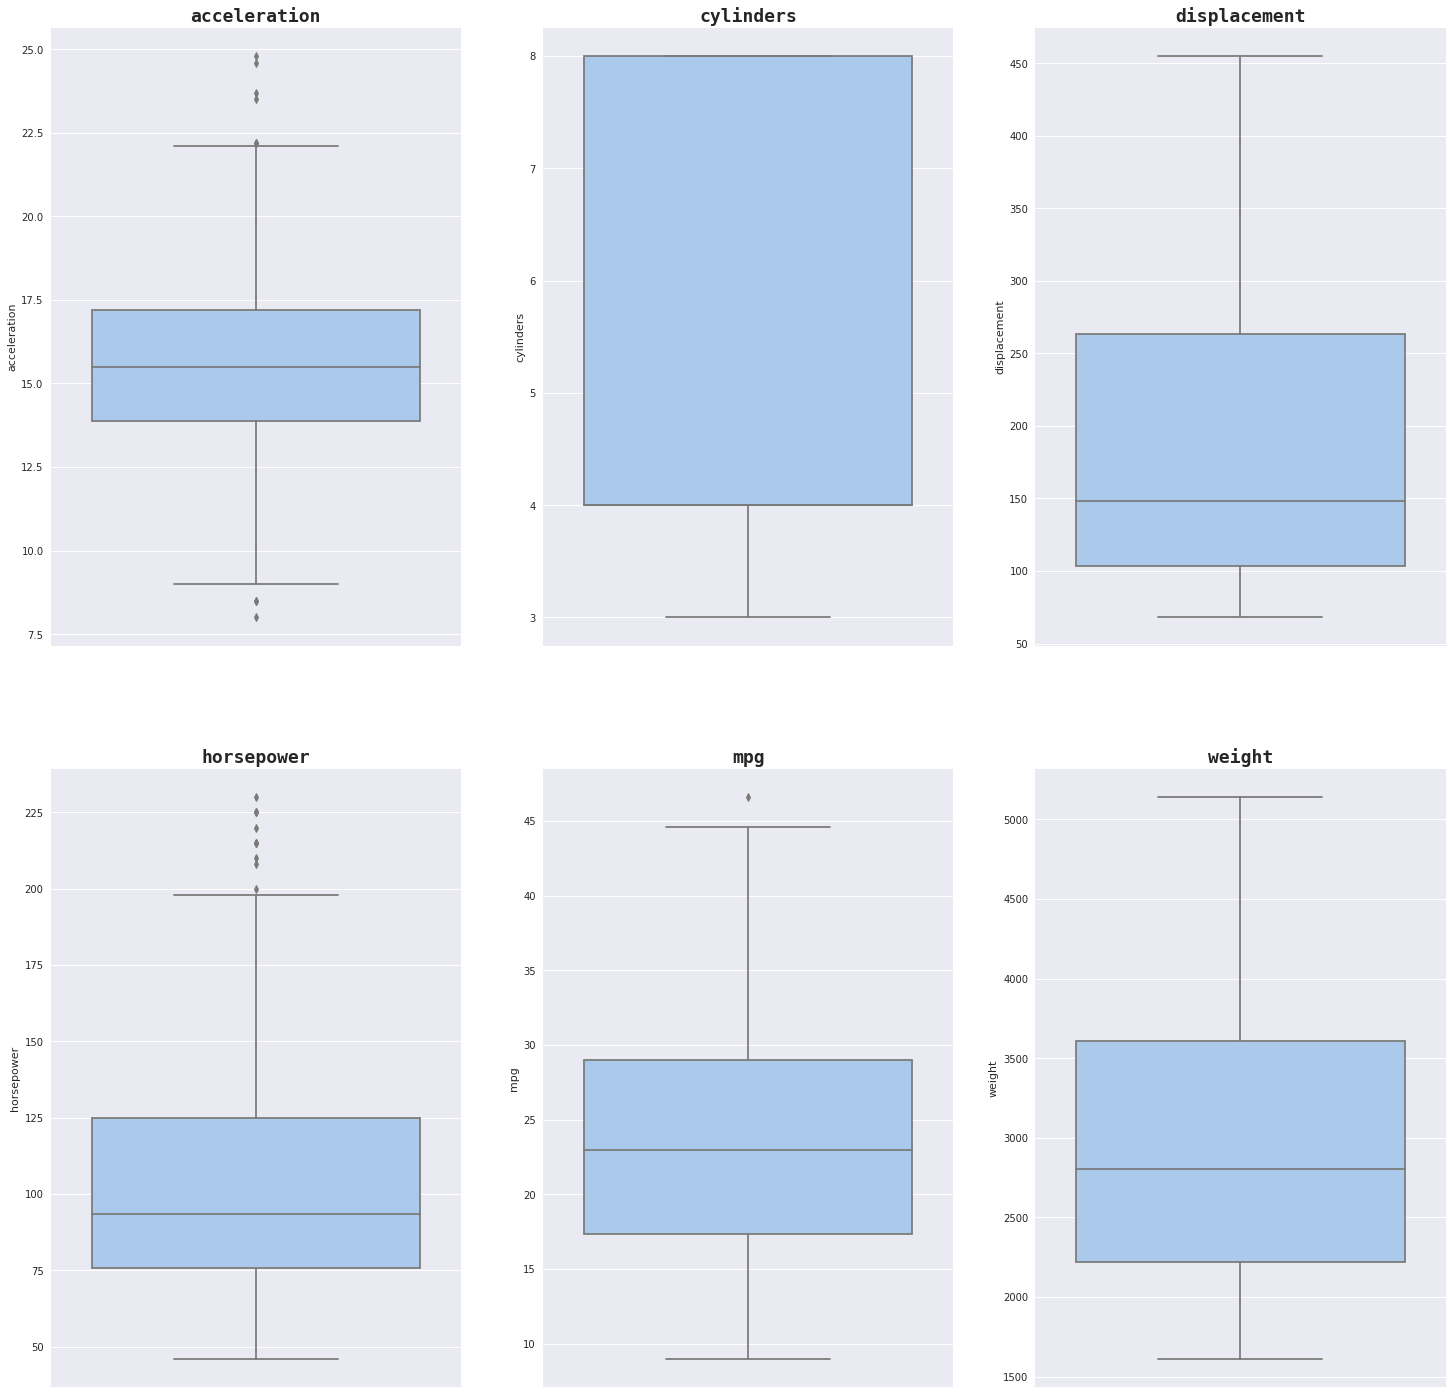

In [15]:
# I will draw boxplots to investigate outliers

fig, ax = plt.subplots(2, 3, figsize = (25, 25))

for i, col in enumerate(num_df.columns):
    g = sns.boxplot(data = df, y = col, ax = ax[i // 3, i % 3], palette = "pastel")
    g.set_title(col, weight = "bold", fontsize = 18, fontname = "monospace")

In [16]:
# let's see how many outliers are in every column
Q1 = num_df.quantile(0.25)
Q3 = num_df.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

#condition
filt = ((num_df < (lower_bound)) | (num_df > (upper_bound)))
filt.sum()

acceleration     9
cylinders        0
displacement     0
horsepower      11
mpg              1
weight           0
dtype: int64

In [17]:
df.loc[filt["acceleration"]]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
7,14.0,8,440.0,215.0,4312,8.5,70,1,plymouth fury iii
9,15.0,8,390.0,190.0,3850,8.5,70,1,amc ambassador dpl
11,14.0,8,340.0,160.0,3609,8.0,70,1,plymouth 'cuda 340
59,23.0,4,97.0,54.0,2254,23.5,72,2,volkswagen type 3
195,29.0,4,85.0,52.0,2035,22.2,76,1,chevrolet chevette
299,27.2,4,141.0,71.0,3190,24.8,79,2,peugeot 504
300,23.9,8,260.0,90.0,3420,22.2,79,1,oldsmobile cutlass salon brougham
326,43.4,4,90.0,48.0,2335,23.7,80,2,vw dasher (diesel)
394,44.0,4,97.0,52.0,2130,24.6,82,2,vw pickup


In [18]:
df.loc[filt["horsepower"]]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
6,14.0,8,454.0,220.0,4354,9.0,70,1,chevrolet impala
7,14.0,8,440.0,215.0,4312,8.5,70,1,plymouth fury iii
8,14.0,8,455.0,225.0,4425,10.0,70,1,pontiac catalina
13,14.0,8,455.0,225.0,3086,10.0,70,1,buick estate wagon (sw)
25,10.0,8,360.0,215.0,4615,14.0,70,1,ford f250
26,10.0,8,307.0,200.0,4376,15.0,70,1,chevy c20
27,11.0,8,318.0,210.0,4382,13.5,70,1,dodge d200
67,11.0,8,429.0,208.0,4633,11.0,72,1,mercury marquis
94,13.0,8,440.0,215.0,4735,11.0,73,1,chrysler new yorker brougham
95,12.0,8,455.0,225.0,4951,11.0,73,1,buick electra 225 custom


In [19]:
df.loc[filt["mpg"]]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
322,46.6,4,86.0,65.0,2110,17.9,80,3,mazda glc


> Those outliers aren't abnormal and i think it's natural thing to have them.<br>
I will **`keep them`**.

In [20]:
df.describe(include = "O")

,origin,car name
count,396,396
unique,3,305
top,1,toyota corolla
freq,247,5


**`car name`** won't be useful anymore, So I will drop it.

In [21]:
df.drop("car name", axis = 1, inplace = True)

# EDA

## Helpful functions

In [22]:
def count_pie(data, col, hue = None, ax = None):
    """
    This function draws a categorical column in count plot and pie plot.
    
    arguments \
    data: dataframe.
    col: col to visualize.
    hue: if you want to add a second variable.
    """
    # draw the count plot
    count =sns.countplot(data = df, x  = col, hue = hue ,palette = "pastel", ax = ax[0])
        # annotating
    for p in count.patches:
        count.annotate("{:.0f}".format(p.get_height()), (p.get_x() + 0.3, p.get_height() + 1), 
                       ha = "center", va = "bottom", color = "black", fontname = "monospace", fontsize = 15, weight = "bold")
    
    # draw pie plot
    labels = data[col].value_counts().sort_index().index
    data = data[col].value_counts().sort_index().values
    colors = sns.color_palette("pastel")[:len(labels)]
    _, labels_lst, percentage_labels_lst = ax[1].pie(data, labels = labels, colors = colors, autopct = "%0.0f%%",
              explode = [0.03 for i in range(len(labels))] )
    
    # labels
    
        # count plot
    count.set_xlabel(f"{col} Count plot", weight = "semibold", fontname = "monospace", fontsize = 15)
    count.set_ylabel("Count", weight = "semibold", fontname = "monospace", fontsize = 15)
    count.set_xticklabels(labels, fontsize = 15, weight = "bold")
    count.set_title(f"{col} count plot", weight = "bold", fontname = "monospace", fontsize = 25)
        # pie plot
    ax[1].set_xlabel(f"{col} Pie plot", weight = "semibold", fontname = "monospace", fontsize = 15)
    for label in labels_lst[:len(labels)]:
        label.update({"weight": "bold", "fontsize":15})
    for label in percentage_labels_lst[:len(labels)]:
        label.update({"weight": "bold", "fontsize":15})

    ax[1].legend(loc = "upper left", frameon = True, prop = {"size":15}, bbox_to_anchor = (1.05, 1))
    ax[1].set_title(f"{col} pie plot", weight = "bold", fontname = "monospace", fontsize = 25)

In [23]:
def plot_hist(df, col, hue = None, ax = None):
    """
     This function Outputs the histogram for the column"
     
     Arguments \
     df: dataframe.
     col: the column to plot the histogram for.
     hue: (optional) to specify if there is a second variable.
     ax: (optional) to specify the axis to draw in.
    """
    plot = sns.histplot(data = df, x = col, kde= True, hue = hue, palette = "pastel", ax = ax)
        
    # titles
    plot.set_title(f"histogram plot for column {col}", fontsize = 15,weight = "bold", 
                fontname = "monospace", pad = 20)
    plot.set_xlabel(col, fontsize = 10,  weight = "semibold", fontname = "monospace")
    plot.set_ylabel("Count", fontsize = 10,  weight = "semibold", fontname = "monospace")

In [24]:
def scatter(df, x, y, ax = None, hue = None, size = None, style = None, alpha = 1):
    """
    This function allows you to plot the scatter plot of 2 variables
    ---
    arguments \
    df: data frame name.
    x: column name to x-axis.
    y: column name to y-axis.
    ax: if there's more than one.
    hue: to add another variable using color.
    size: to add another variable using size.
    style: to add another variable using style.
    """
    g = sns.scatterplot(data = df, x = x, y = y, ax  = ax , hue = hue,
                    size = size, style = style, markers = True, alpha = alpha, palette = "pastel")
    
    # titles
    g.set_title(f"{y} with {x}", fontsize = 17, weight = "bold", fontname = "monospace", pad = 20)
    g.set_xlabel(x, fontsize = 15, weight = "semibold", fontname = "monospace")
    g.set_ylabel(y, fontsize = 15, weight = "semibold", fontname = "monospace")

In [25]:
def violin(df, y, x = None, hue = None, ax = None):
    """
    This function allows you to plot the violin plot of a continuous variable.
    ---
    arguments \
    df: dataframe name.
    col: column name.
    hue: to add another variable.
    ax: to specify axis to draw in.
    """
    g = sns.violinplot(data = df, x = x, y = y, hue = hue, palette = "pastel", ax = ax)
    
    # titles
    g.set_title(f"{y} violin plot with {x}", fontsize = 17, weight = "bold", fontname = "monospace", pad = 20)
    g.set_xlabel(x, fontsize = 15, weight = "semibold", fontname = "monospace")
    g.set_ylabel(y, fontsize = 15, weight = "semibold", fontname = "monospace")

## Correlations

In [26]:
df.corr()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year
mpg,1.000000,-0.775012,-0.804983,-0.774151,-0.832013,0.422836,0.578207
cylinders,-0.775012,1.000000,0.951119,0.841516,0.895995,-0.508429,-0.346809
displacement,-0.804983,0.951119,1.000000,0.895690,0.932842,-0.546266,-0.369455
horsepower,-0.774151,0.841516,0.895690,1.000000,0.862390,-0.689302,-0.413209
weight,-0.832013,0.895995,0.932842,0.862390,1.000000,-0.419963,-0.305113
acceleration,0.422836,-0.508429,-0.546266,-0.689302,-0.419963,1.000000,0.292269
model year,0.578207,-0.346809,-0.369455,-0.413209,-0.305113,0.292269,1.000000


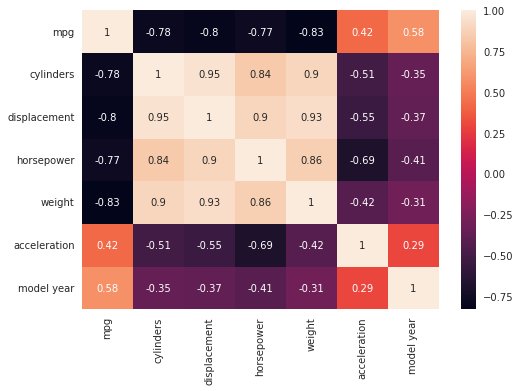

In [27]:
sns.heatmap(df.corr(), annot = True)
plt.show()

>**Observations**:
>- There are strong **Positive** correlations between **`weight`** , **`horsepower`**, **`displacement`**, **`cylindrers`**.<br>This makes sense, **because for example the more cylinders the car have the more horsepower**.<br><br>
>- There are strong **Negative** correlations between **`mpg`** and each of the following<br> **[`weight`, `horsepower`, `displacement`, `cylindrers`]** .<br>This is reasonable, **becauser when the car is more powerful it requires more gallons**.

## Categorical columns

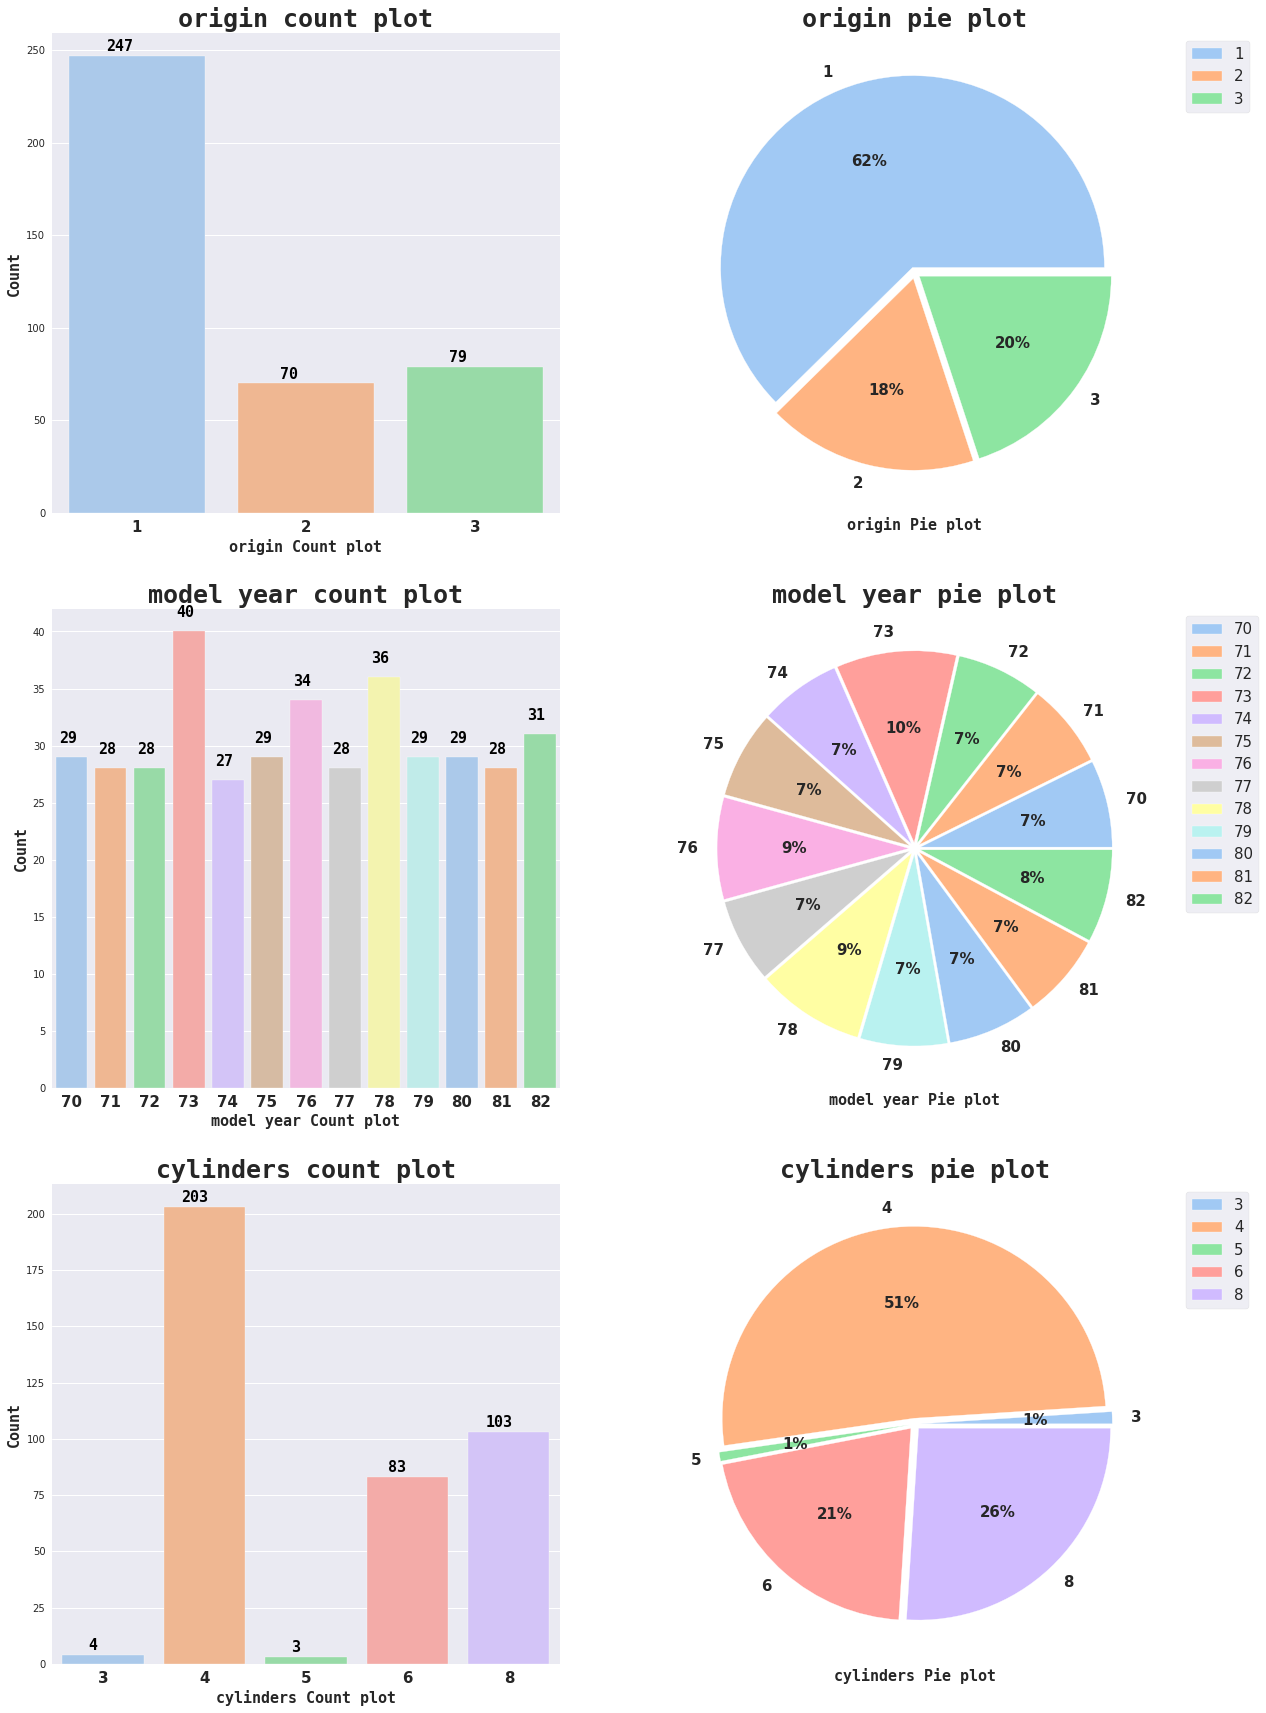

In [28]:
cat_cols = ["origin", "model year", "cylinders"]
fig, ax = plt.subplots(3, 2, figsize = (20, 30))
for i, col in enumerate(cat_cols):
    count_pie(df, col, ax = (ax[i % 3, i//3], ax[i%3, i//3 + 1]))

> **`origin`**
>- **Majority** of the cars have origin **`1`**.
>- Origin **`3`** is higher than origin **`2`** but the difference is **negligible**.

> **`model year`**
>- The **most frequent year** is **`1973`** with frequency = **`4`** times.
>- **`1978`** and **`1976`** are in the **second** place with frequency **`36`** and **`34`** respectively.
>- **Rest** of the years are close to each other with **frequency** almost **`28`**.

>**`cylinders`**
>- **Most** cars have **`4`** cylinders **`203`** cars.
>- **A lot of cars** have **`6`** and **`8`** cylinders also, **`83`** and **`103`** respectively.
>- **Only a few** cars have **`3`** and **`5`** cylinders, **`4`** and **`3`** respectively.

## Numerical columns

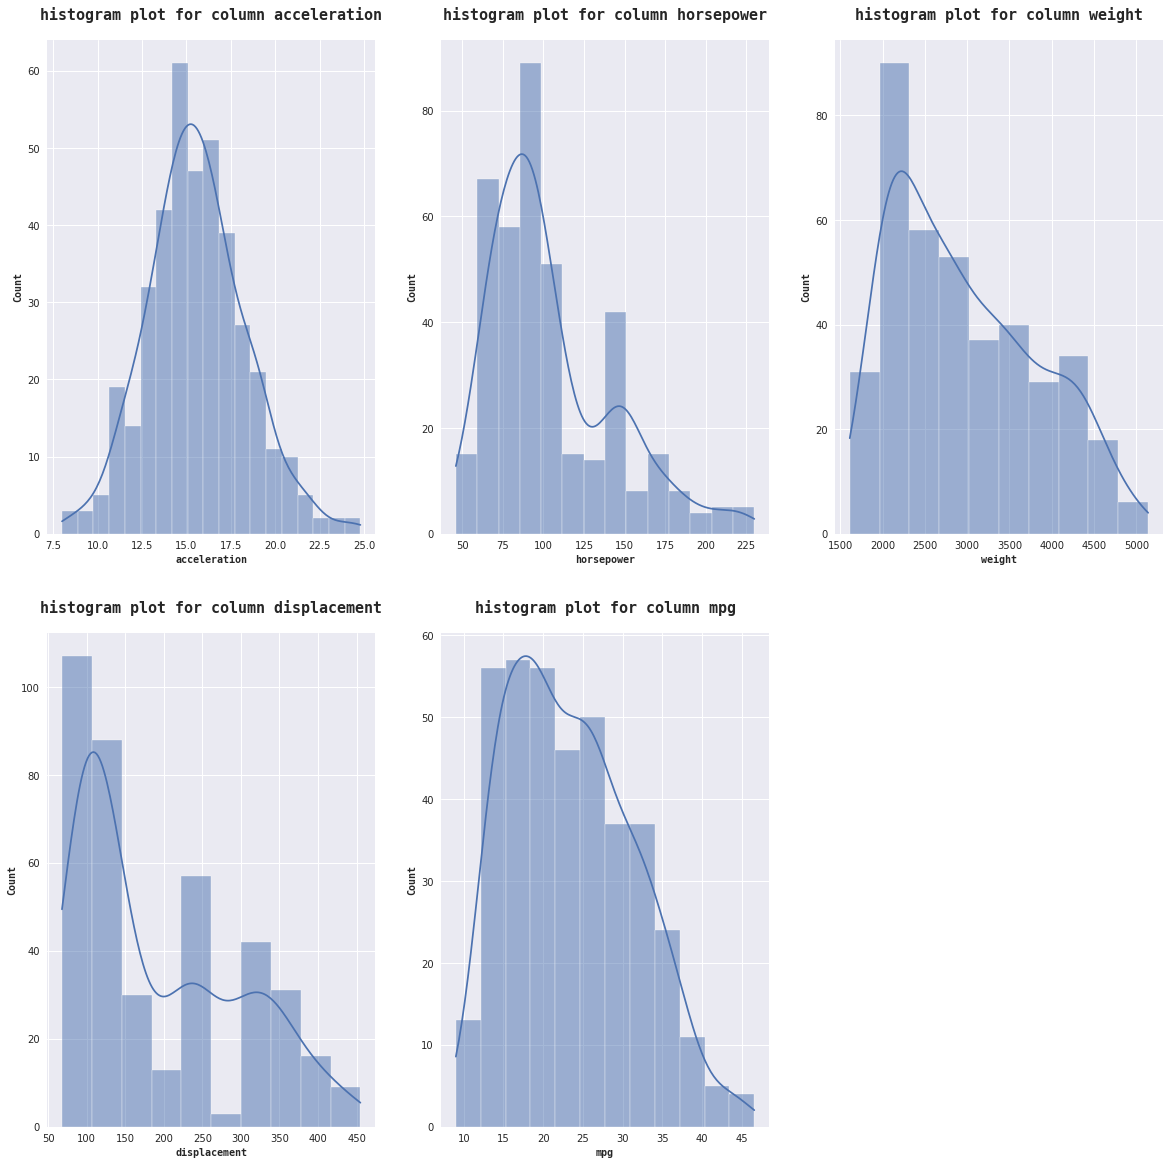

In [29]:
num_cols = ["acceleration", "horsepower", "weight", "displacement", "mpg"]
fig, ax = plt.subplots(2,3, figsize = (20, 20))
for i, col in enumerate(num_cols):
    plot_hist(df, col, ax = ax[i//3, i%3])
ax[1, 2].remove()

>**`acceleration`**
>- The distribution is **`symmetric`**.
>- The **most frequent** value is about **`15`**.

>**`horsepower`**
>- The distribution is **`right skewed`**. A **small number** of cars have high **`horsepower`**.
>- The **|mose frequent** value is about **`85`** but the distribution is  **`bimodal`**.
> We can notice that there is a another mode at **`150`**.\

>**`weight`**
>- The distribution is **`right skewed`**. A **small number** of cars have **high** **`weight`**.
>- The **most frequent** value is about **`2250`**.

>**`displacement`**
>- The distribution is **`right skewed`**. A **small number** of cars **high** **`displacment`** valus.
>- The **most frequent** value is about **`100`**.

>**`mpg`**
>- The distribution is **`right skewed`**. which means that a **small number** of cars are **efficient**.
>- **Most** of cars have mpg about 12 - 27.

## Numerical columns with origin

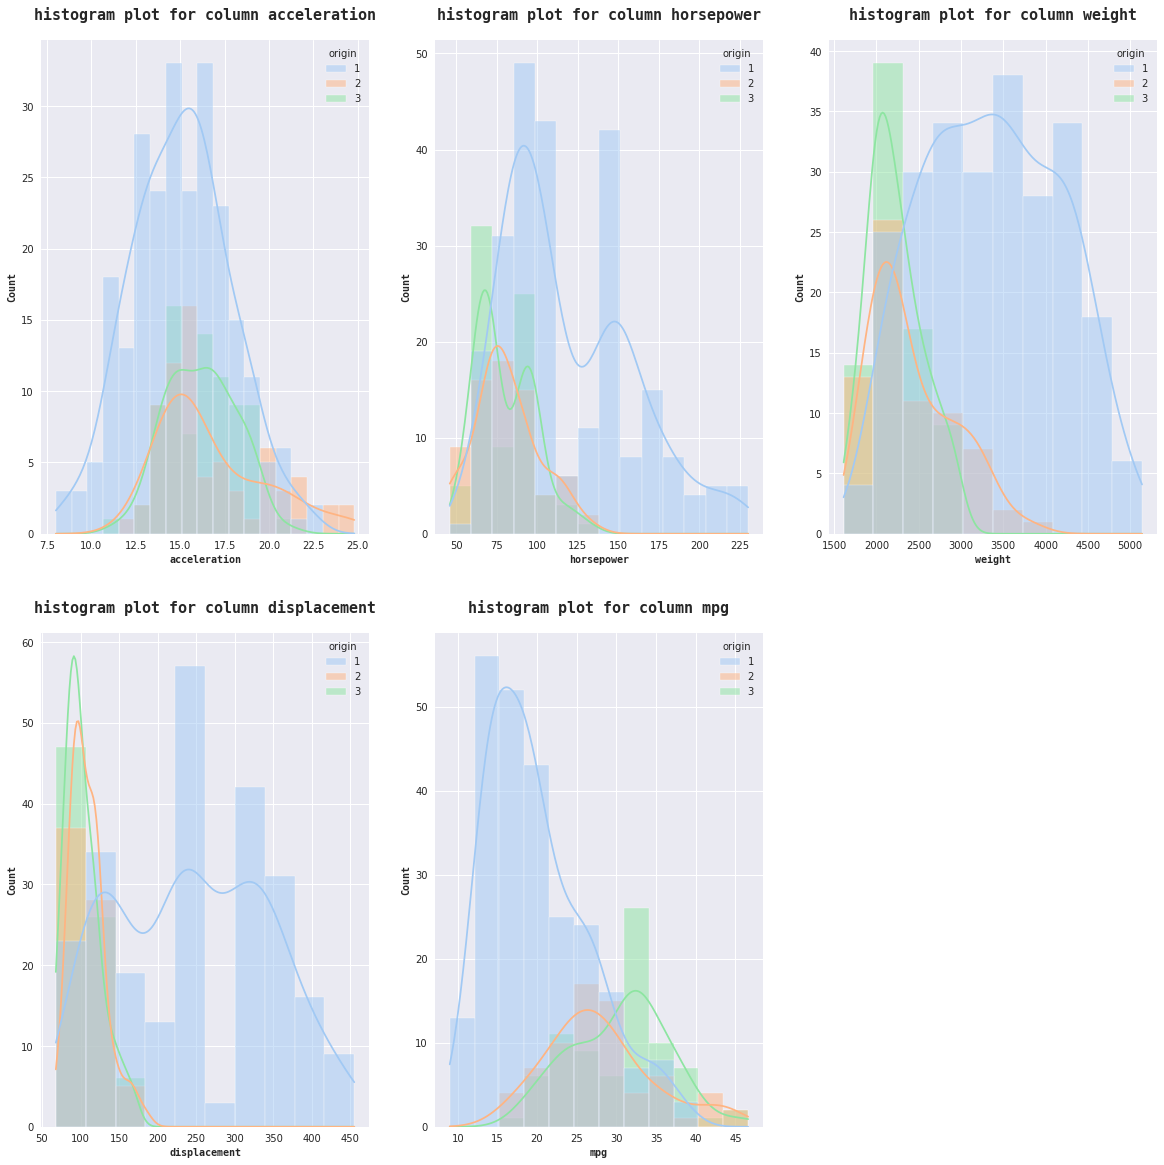

In [30]:
num_cols = ["acceleration", "horsepower", "weight", "displacement", "mpg"]
fig, ax = plt.subplots(2,3, figsize = (20, 20))
for i, col in enumerate(num_cols):
    plot_hist(df, col, ax = ax[i//3, i%3], hue = "origin")
ax[1, 2].remove()

>- It's clear the cars of **`origin 1`** have **lower** **`mpg`** and **higher** **`displacement`**, **`horsepower`**, **`weight`**.
>- **`Origin 2`** and **`origin 3`** have **similar distributions**.
>- **`acceleration`** is the **similiar** for all values of **`origin`**.

## mpg with numerical columns

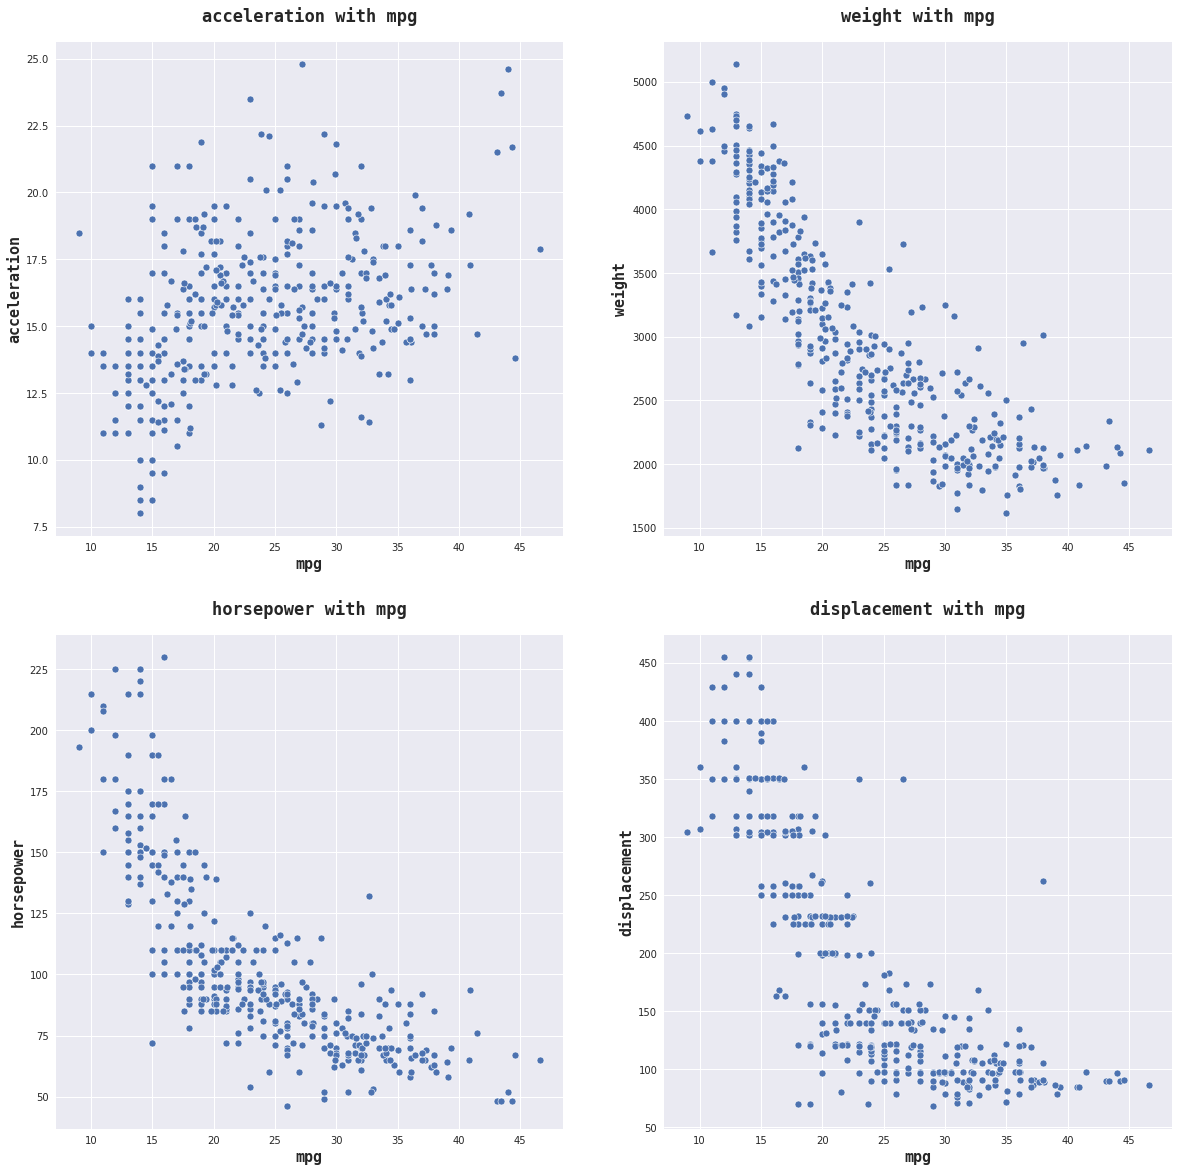

In [31]:
num_cols = ["acceleration", "horsepower", "weight", "displacement"]
fig, ax = plt.subplots(2,2, figsize = (20, 20))
for i, col in enumerate(num_cols):
    scatter(df, "mpg", col, ax = ax[i%2, i//2])

>- **`mpg`** has a strong **negative** correlation with **`horsepower`** , **`displacement`**and **`weight`**.
>>- When **`horsepower`** **increases**, it's reasonable that the car will **require more gallons**.
>>- When the **`weight`** of the car **increases**, the resistance will increase and the car will **need more gallons**.
>>- When the **`displacement`** **increases**, the **more gallons the motor burns**.
>- It looks like there is **no correlation** between **`mpg`** and **`acceleration`**.

## mpg with cylinders

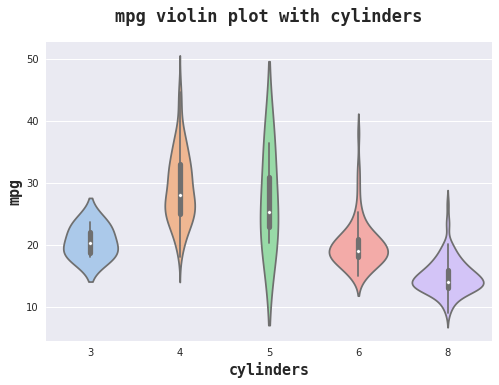

In [32]:
violin(df, y = "mpg", x= "cylinders")

>- Cars with 4 cylinders have **the bigger mean** for **`mpg`**.

## mpg with model year

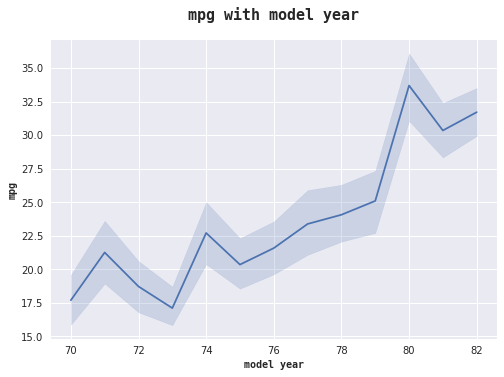

In [33]:
plot = sns.lineplot(data = df, x = "model year", y = "mpg")
# titles
plot.set_title("mpg with model year", fontsize = 15,weight = "bold", 
            fontname = "monospace", pad = 20)
plot.set_xlabel("model year", fontsize = 10,  weight = "semibold", fontname = "monospace")
plot.set_ylabel("mpg", fontsize = 10,  weight = "semibold", fontname = "monospace")
plt.show()

>- It's clear that mpg **`increases`** .<br>
except for year **`1973`** which noticed a **fall** in mpg value.<br>
-**The rate of increasing** has itself **increased** in years **`1979-1980`**.
Then it had another **fall** in year **`1981`**. and looks like it **increased** again in **`1982`**.

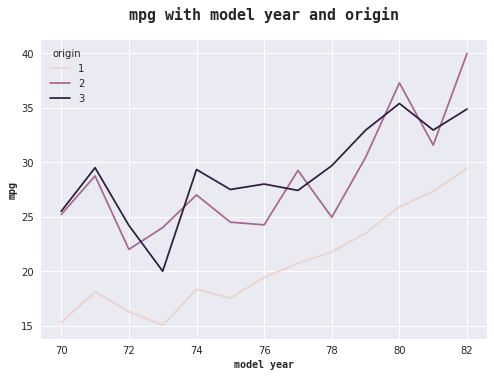

In [34]:
plot = sns.lineplot(data = df, x = "model year", y = "mpg", hue = "origin", ci = None)
# titles
plot.set_title("mpg with model year and origin", fontsize = 15,weight = "bold", 
            fontname = "monospace", pad = 20)
plot.set_xlabel("model year", fontsize = 10,  weight = "semibold", fontname = "monospace")
plot.set_ylabel("mpg", fontsize = 10,  weight = "semibold", fontname = "monospace")
plt.show()

>- **`mpg`** is increasing for all origins.
>- But you can see that **`mpg`** for cars of **`origin 1`** are always less than **`origin 2 and 3`**.

## Other numerical relations

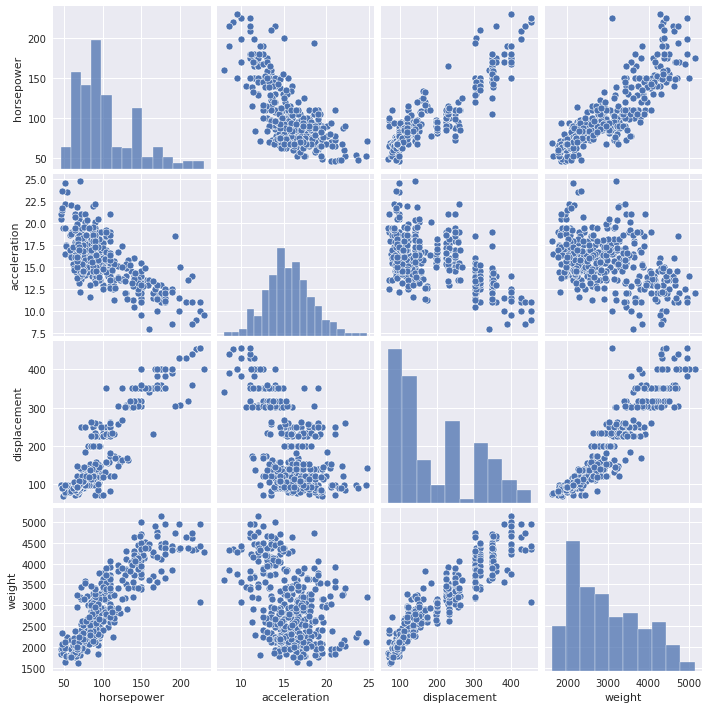

In [35]:
sns.pairplot(df, vars = ["horsepower", "acceleration", "displacement", "weight"])
plt.show()

>- Looks like **`horsepower`** and **`acceleration`** have a **negative** correlation.
Which I think is surprising.
>- The rest **confirms** what we said before about **correlations**.

# Modeling

In [36]:
# train-test split
X = df.drop("mpg", axis = 1)
y = df["mpg"]

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [38]:
for data in (X_train, X_test, y_train, y_test):
    print(data.shape)

(316, 7)
(80, 7)
(316,)
(80,)


In [39]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [40]:
regs = [KNeighborsRegressor(), LinearRegression(),
              Lasso(), Ridge(), ElasticNet(), AdaBoostRegressor(), SVR(),
              RandomForestRegressor(), DecisionTreeRegressor(),
              ExtraTreesRegressor(), GradientBoostingRegressor()]

model_name = []
model_mae = []

In [41]:
for reg in regs:
    y_pred = cross_val_predict(reg, X_train, y_train, cv = 3)
    model_name.append(reg.__class__.__name__)
    model_mae.append(mae(y_train, y_pred))

In [42]:
final = pd.DataFrame({"name": model_name,"mae": model_mae})
final.sort_values(by = "mae", inplace = True)
final

,name,mae
9,ExtraTreesRegressor,1.984373
7,RandomForestRegressor,2.045652
10,GradientBoostingRegressor,2.060937
0,KNeighborsRegressor,2.206709
5,AdaBoostRegressor,2.290798
6,SVR,2.329698
3,Ridge,2.583640
1,LinearRegression,2.594567
2,Lasso,2.731777
8,DecisionTreeRegressor,2.788924


In [43]:
model = ExtraTreesRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mae(y_test, y_pred)

1.792924999999999